In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from conex.behaviors.synapses import dendrites
from conex.behaviors.neurons import specs, homeostasis
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

NameError: name '_C' is not defined

# Define the Network

In [ ]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = torch.relu(self.hidden(x))
        x = self.output(x)
        return x


Implement STDP Learning Rule:



In [ ]:
class STDP(nn.Module):
    def __init__(self, pre_neurons, post_neurons, learning_rate):
        super(STDP, self).__init__()
        self.pre_neurons = pre_neurons
        self.post_neurons = post_neurons
        self.learning_rate = learning_rate
    
    def forward(self, pre_spike, post_spike):
        delta_w = self.learning_rate * pre_spike * post_spike
        self.pre_neurons.weight.data += delta_w


Lateral Inhibition Mechanism:



In [ ]:
def lateral_inhibition(layer_output, inhibition_factor=0.5):
    inhibition = torch.mean(layer_output) * inhibition_factor
    inhibited_output = layer_output - inhibition
    inhibited_output[inhibited_output < 0] = 0
    return inhibited_output


Train the Network and Document Results:



In [ ]:
def train_network(network, data, labels, epochs=100, lr=0.01):
    criterion = nn.MSELoss()
    optimizer = optim.SGD(network.parameters(), lr=lr)
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')


Create a New Neural Network with Expanded Hidden Layer:



In [ ]:
class ComplexNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ComplexNN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        self.stdp = STDP(self.hidden, self.output, learning_rate=0.01)
    
    def forward(self, x):
        x = torch.relu(self.hidden(x))
        x = self.output(x)
        return x
    
    def apply_stdp(self, pre_spike, post_spike):
        self.stdp(pre_spike, post_spike)


Add k-Winners-Take-All Mechanism:



In [ ]:
def k_winners_take_all(layer_output, k):
    topk_values, topk_indices = torch.topk(layer_output, k)
    mask = torch.zeros_like(layer_output)
    mask.scatter_(1, topk_indices, topk_values)
    return mask


Add Homeostasis Mechanism:



In [ ]:
def homeostasis(layer_output, target=0.1, factor=0.01):
    current_mean = torch.mean(layer_output)
    adjustment = factor * (target - current_mean)
    adjusted_output = layer_output + adjustment
    return adjusted_output


In [ ]:
# Data preparation
input_size = 10
hidden_size = 5
output_size = 2
data = torch.rand((100, input_size)).float()
labels = torch.randint(0, 2, (100, output_size)).float()


In [ ]:
def train_and_store_results(network, data, labels, config_name, epochs=100, lr=0.01):
    criterion = nn.MSELoss()
    optimizer = optim.SGD(network.parameters(), lr=lr)
    losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    
    hidden_output = network.hidden(data)
    
    if config_name == 'Lateral Inhibition':
        hidden_output = lateral_inhibition(hidden_output)
    elif config_name == 'k-Winners-Take-All':
        hidden_output = k_winners_take_all(hidden_output, k=2)
    elif config_name == 'Homeostasis':
        hidden_output = homeostasis(hidden_output)
    elif config_name == 'All Mechanisms':
        hidden_output = lateral_inhibition(hidden_output)
        hidden_output = k_winners_take_all(hidden_output, k=2)
        hidden_output = homeostasis(hidden_output)
    
    final_output = network.output(hidden_output)
    return losses, hidden_output.detach().numpy(), final_output.detach().numpy()

# Train and store results for each configuration
configs = ['No Mechanism', 'Lateral Inhibition', 'k-Winners-Take-All', 'Homeostasis', 'All Mechanisms']
results = {}

for config in configs:
    network = ComplexNN(input_size, hidden_size, output_size)
    losses, hidden_output, final_output = train_and_store_results(network, data, labels, config)
    results[config] = {'losses': losses, 'hidden_output': hidden_output, 'final_output': final_output}


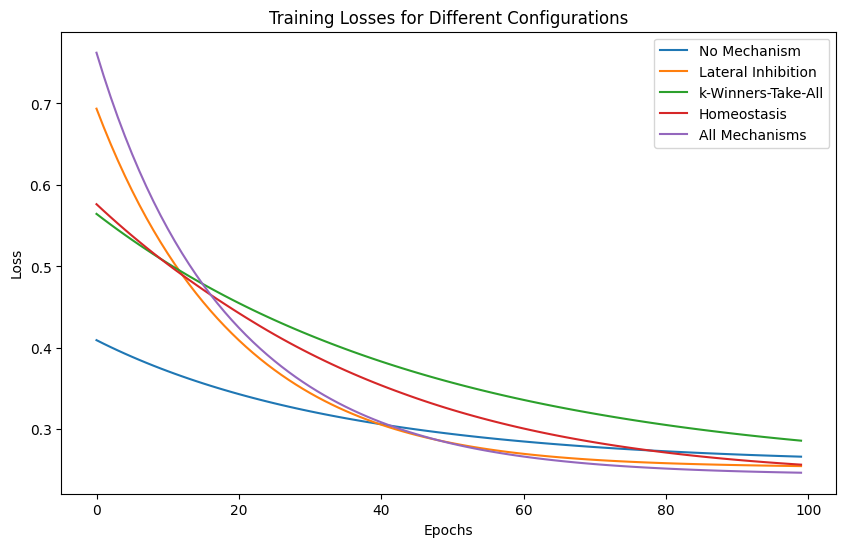

In [ ]:
plt.figure(figsize=(10, 6))
for config in configs:
    plt.plot(results[config]['losses'], label=config)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses for Different Configurations')
plt.legend()
plt.show()


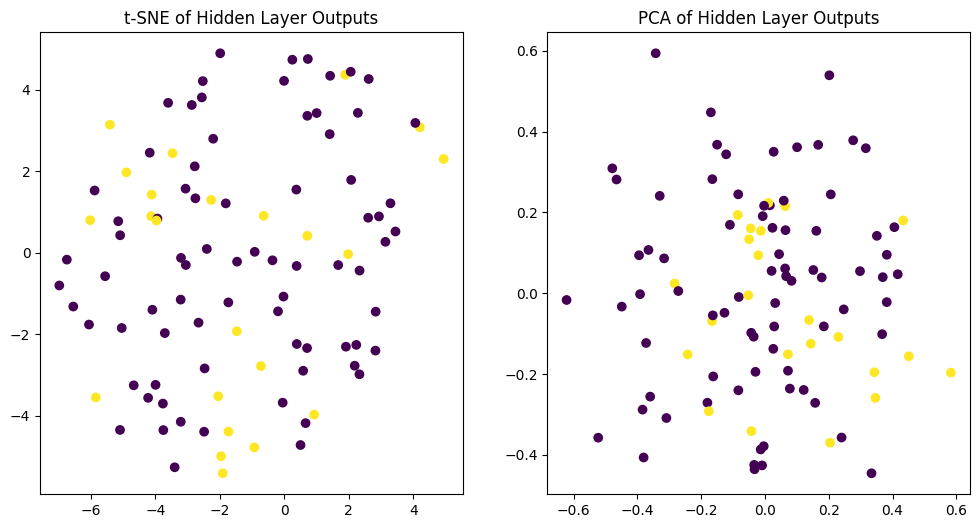

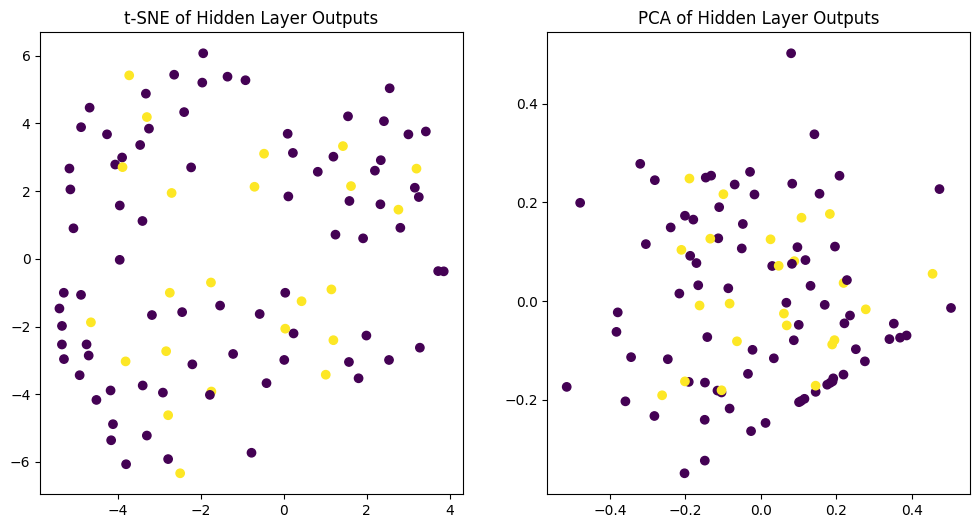

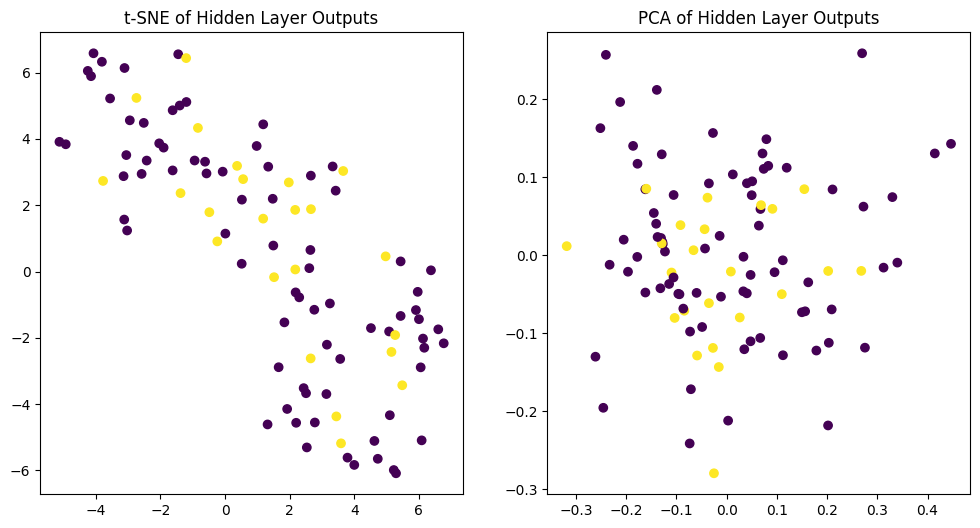

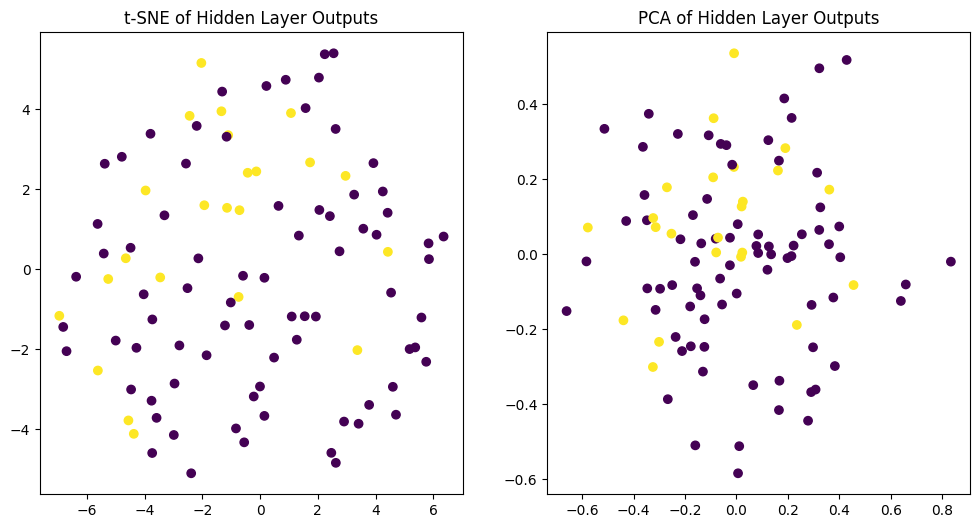

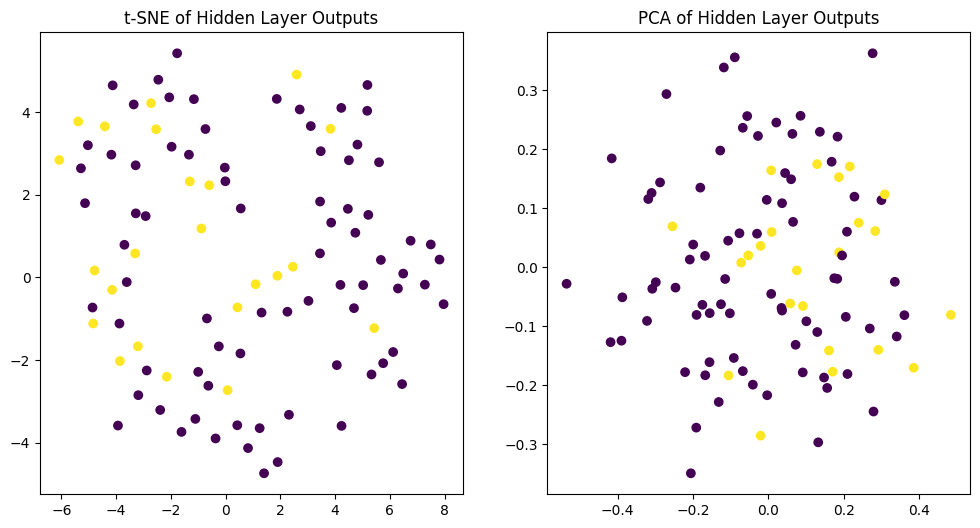

In [ ]:
def plot_hidden_outputs(hidden_outputs, labels):
    tsne = TSNE(n_components=2)
    pca = PCA(n_components=2)

    hidden_tsne = tsne.fit_transform(hidden_outputs)
    hidden_pca = pca.fit_transform(hidden_outputs)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.scatter(hidden_tsne[:, 0], hidden_tsne[:, 1], c=labels, cmap='viridis')
    plt.title('t-SNE of Hidden Layer Outputs')

    plt.subplot(1, 2, 2)
    plt.scatter(hidden_pca[:, 0], hidden_pca[:, 1], c=labels, cmap='viridis')
    plt.title('PCA of Hidden Layer Outputs')

    plt.show()

# Plotting hidden layer outputs for each configuration
for config in configs:
    hidden_output = results[config]['hidden_output']
    plot_hidden_outputs(hidden_output, labels.argmax(axis=1))


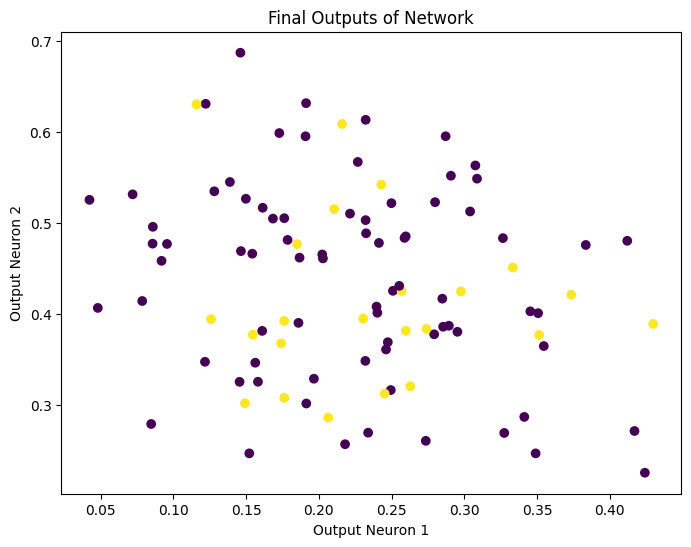

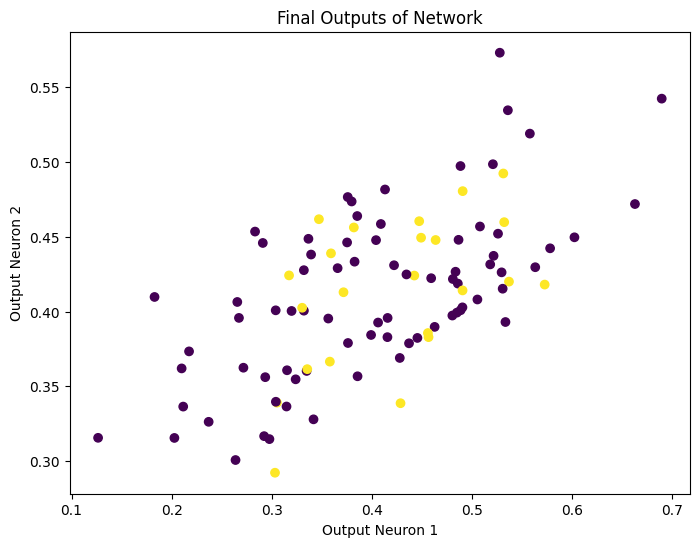

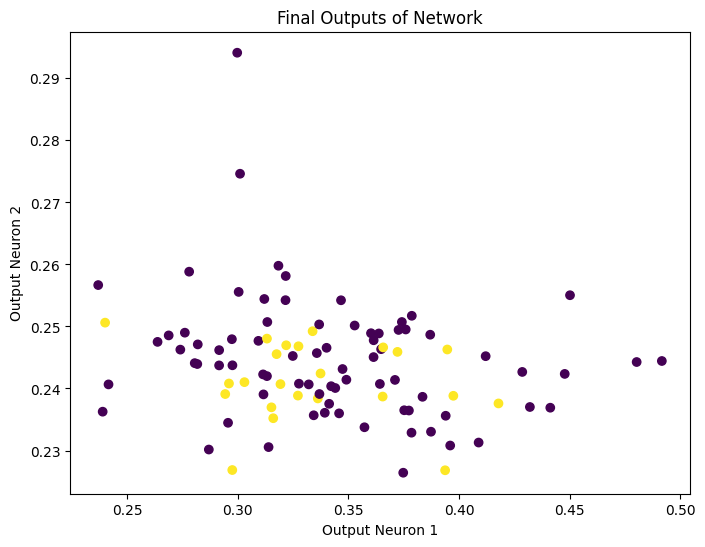

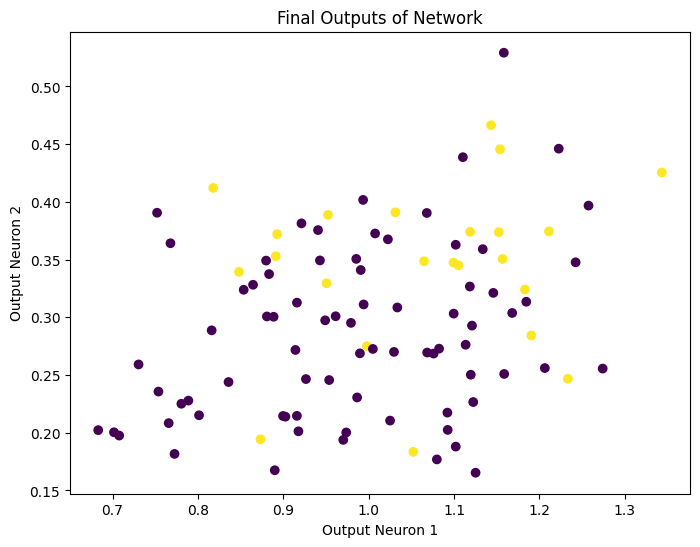

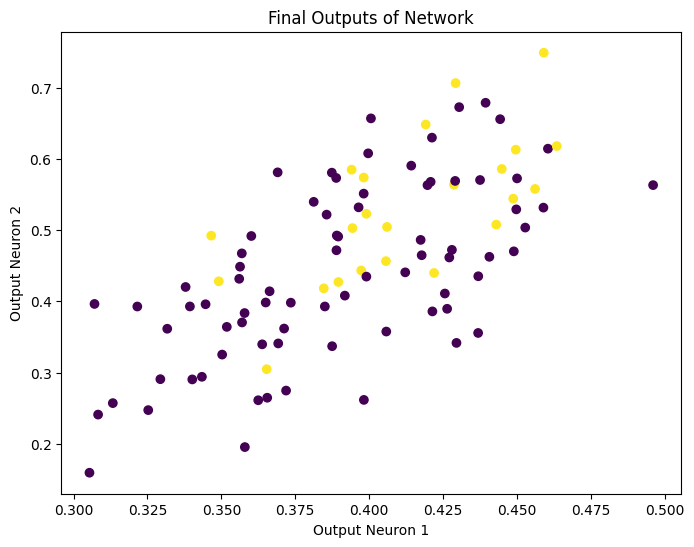

In [ ]:
def plot_final_outputs(final_outputs, labels):
    plt.figure(figsize=(8, 6))
    plt.scatter(final_outputs[:, 0], final_outputs[:, 1], c=labels, cmap='viridis')
    plt.xlabel('Output Neuron 1')
    plt.ylabel('Output Neuron 2')
    plt.title('Final Outputs of Network')
    plt.show()

# Plotting final outputs for each configuration
for config in configs:
    final_output = results[config]['final_output']
    plot_final_outputs(final_output, labels.argmax(axis=1))


In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from torchviz import make_dot

# Define necessary classes and functions
class ComplexNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ComplexNN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = torch.relu(self.hidden(x))
        x = self.output(x)
        return x
    
    def apply_stdp(self, pre_spike, post_spike, lr=0.01, tau_pre=20.0, tau_post=20.0, a_pre=0.005, a_post=-0.005):
        delta_t = pre_spike - post_spike
        dw = lr * (a_pre * torch.exp(-delta_t / tau_pre) + a_post * torch.exp(delta_t / tau_post))
        self.hidden.weight.data += dw

# Define mechanisms
def lateral_inhibition(layer_output, inhibition_factor=0.5):
    inhibition = torch.mean(layer_output) * inhibition_factor
    inhibited_output = layer_output - inhibition
    inhibited_output[inhibited_output < 0] = 0
    return inhibited_output

def k_winners_take_all(layer_output, k):
    topk_values, topk_indices = torch.topk(layer_output, k)
    mask = torch.zeros_like(layer_output)
    mask.scatter_(1, topk_indices, topk_values)
    return mask

def homeostasis(layer_output, target=0.1, factor=0.01):
    current_mean = torch.mean(layer_output)
    adjustment = factor * (target - current_mean)
    adjusted_output = layer_output + adjustment
    return adjusted_output

# Data preparation
input_size = 10
hidden_size = 5
output_size = 2
data = torch.rand((100, input_size)).float()
labels = torch.randint(0, 2, (100, output_size)).float()

# Train and store results
def train_and_store_results(network, data, labels, epochs=100, lr=0.01, mechanism=None, k=None):
    criterion = nn.MSELoss()
    optimizer = optim.SGD(network.parameters(), lr=lr)
    losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        # Apply STDP after the main update
        if mechanism == 'STDP':
            pre_spike = data
            post_spike = torch.relu(network.hidden(data))
            network.apply_stdp(pre_spike, post_spike)
    
    hidden_output = network.hidden(data)

    if mechanism == 'Lateral Inhibition':
        hidden_output = lateral_inhibition(hidden_output)
    elif mechanism == 'k-Winners-Take-All':
        hidden_output = k_winners_take_all(hidden_output, k)
    elif mechanism == 'Homeostasis':
        hidden_output = homeostasis(hidden_output)
    elif mechanism == 'All Mechanisms':
        hidden_output = lateral_inhibition(hidden_output)
        hidden_output = k_winners_take_all(hidden_output, k)
        hidden_output = homeostasis(hidden_output)
        pre_spike = data
        post_spike = torch.relu(network.hidden(data))
        network.apply_stdp(pre_spike, post_spike)
    
    final_output = network.output(hidden_output)
    return losses, hidden_output.detach().numpy(), final_output.detach().numpy()

# Initialize the network
network = ComplexNN(input_size, hidden_size, output_size)

# Define configurations
configs = ['No Mechanism', 'Lateral Inhibition', 'k-Winners-Take-All', 'Homeostasis', 'STDP']
results = {}

# Train and apply mechanisms incrementally
for config in configs:
    if config == 'No Mechanism':
        losses, hidden_output, final_output = train_and_store_results(network, data, labels)
    elif config == 'Lateral Inhibition':
        losses, hidden_output, final_output = train_and_store_results(network, data, labels, mechanism='Lateral Inhibition')
    elif config == 'k-Winners-Take-All':
        losses, hidden_output, final_output = train_and_store_results(network, data, labels, mechanism='k-Winners-Take-All', k=2)
    elif config == 'Homeostasis':
        losses, hidden_output, final_output = train_and_store_results(network, data, labels, mechanism='Homeostasis')
    elif config == 'STDP':
        losses, hidden_output, final_output = train_and_store_results(network, data, labels, mechanism='STDP')
    
    results[config] = {'losses': losses, 'hidden_output': hidden_output, 'final_output': final_output}

# Plotting training losses
plt.figure(figsize=(10, 6))
for config in configs:
    plt.plot(results[config]['losses'], label=config)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses for Different Configurations')
plt.legend()
plt.show()

# Plotting hidden layer outputs
def plot_hidden_outputs(hidden_outputs, labels):
    tsne = TSNE(n_components=2)
    pca = PCA(n_components=2)

    hidden_tsne = tsne.fit_transform(hidden_outputs)
    hidden_pca = pca.fit_transform(hidden_outputs)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.scatter(hidden_tsne[:, 0], hidden_tsne[:, 1], c=labels, cmap='viridis')
    plt.title('t-SNE of Hidden Layer Outputs')

    plt.subplot(1, 2, 2)
    plt.scatter(hidden_pca[:, 0], hidden_pca[:, 1], c=labels, cmap='viridis')
    plt.title('PCA of Hidden Layer Outputs')

    plt.show()

for config in configs:
    hidden_output = results[config]['hidden_output']
    plot_hidden_outputs(hidden_output, labels.argmax(axis=1))

# Plotting final outputs
def plot_final_outputs(final_outputs, labels):
    plt.figure(figsize=(8, 6))
    plt.scatter(final_outputs[:, 0], final_outputs[:, 1], c=labels, cmap='viridis')
    plt.xlabel('Output Neuron 1')
    plt.ylabel('Output Neuron 2')
    plt.title('Final Outputs of Network')
    plt.show()

for config in configs:
    final_output = results[config]['final_output']
    plot_final_outputs(final_output, labels.argmax(axis=1))

# Visualizing network architecture
def plot_network_architecture(model, input_size):
    x = torch.rand(1, input_size).float()
    y = model(x)
    make_dot(y, params=dict(model.named_parameters())).render("network_architecture", format="png")

plot_network_architecture(network, input_size)


NameError: name '_C' is not defined